This is a simple example using Transfer Learning for an image recognition problem.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -n /content/drive/MyDrive/banana_test.zip -d /content/
!unzip -n /content/drive/MyDrive/banana_train.zip -d /content/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/banana_train/p_train_aug/augmented_image_5499.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_55.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_550.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5500.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5501.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5502.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5503.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5504.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5505.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5506.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5507.jpg  
  inflating: /content/banana_train/p_train_aug/augmented_image_5508.jpg  
  inflating: /content/banana_train/p_train_aug/augmented

In [3]:
import os; import gdown
nomeArq="banana-detection.zip"
if not os.path.exists(nomeArq):
  os.system("gdown 1J7IEFUlq8_ORnKGR3mthNjEQ5ecXmZY_")
os.system("unzip -u "+nomeArq)

0

# Imports de Libs

In [5]:
!pip install keras keras_cv --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 52.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [2]:
# General Libs
import tensorflow
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L as BaseNet, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Layer, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomRotation, RandomWidth, RandomHeight, RandomZoom, RandomBrightness, RandomContrast, GaussianNoise, RandomFlip, Rescaling, Resizing, RandomCrop
from keras_cv.layers import RandomShear, RandomSaturation
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(keras.__version__)
print(tensorflow.__version__)

3.6.0
2.17.0


# Lendo o dataset

In [47]:
# Alguns parâmetros para leitura do dataset

TRAINING_DIR = 'banana_train'
TEST_DIR = 'banana_test'
im_size=(224,224)

seed = 666

BATCH_SIZE = 10

In [48]:
# Train and Validation datasets using validation_split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=im_size,  # Target size for the images
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=im_size,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Test dataset without validation split
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode='binary',
    seed=seed,
    image_size=im_size,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 85269 files belonging to 2 classes.
Using 68216 files for training.
Found 85269 files belonging to 2 classes.
Using 17053 files for validation.
Found 254 files belonging to 2 classes.


# Data Augmentation Layer (Keras 3.x/KerasCV)

In [49]:
data_augmentation = Sequential([
    RandomCrop(height=im_size[0], width=im_size[1]),
    RandomSaturation((0.4, 0.6)),  # Adjust saturation
    RandomRotation(0.05, fill_mode='nearest', fill_value=0),  # Random rotation
    RandomWidth(0.01),  # Width shift
    RandomHeight(0.01),  # Height shift
    RandomShear(0.01, fill_mode='nearest', fill_value=0),  # Shear
    RandomZoom(0.01, 0.01, fill_mode='nearest', fill_value=0),  # Zoom
    RandomBrightness(factor=0.1),  # Brightness
    RandomContrast(factor=0.1),  # Contrast
    GaussianNoise(0.1),  # Gaussian noise
    RandomFlip(mode="horizontal_and_vertical"),  # Random flip
    Resizing(im_size[0], im_size[1]),  # Resize back to im_size
    #Rescaling(scale=1./127.5, offset=-1)  # Normalize pixel values - needed if include_preprocessing=False
])

no_augmentation = Sequential([
    Resizing(im_size[0], im_size[1]),  # Resize back to im_size
    #Rescaling(scale=1./127.5, offset=-1)  # Normalize pixel values needed if include_preprocessing=False
])


In [50]:
# Apply data augmentation (which includes normalization) to the training dataset
#augmented_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_dataset = train_dataset.map(lambda x, y: (no_augmentation(x, training=True), y))

# Apply only normalization to the validation and test datasets (no augmentation)
normalized_validation_dataset = validation_dataset.map(lambda x, y: (no_augmentation(x, training=True), y))
normalized_test_dataset = test_dataset.map(lambda x, y: (no_augmentation(x, training=True), y))

# Obtain class information
class_names = train_dataset.class_names
print('Classes: ' + str(class_names))
num_classes = len(class_names)

# Optional: Count the samples in each dataset (can also check dynamically during training)
nb_train_samples = len(train_dataset.file_paths)
nb_validation_samples = len(validation_dataset.file_paths)
nb_test_samples = len(test_dataset.file_paths)


Classes: ['n_crop', 'p_train_aug']


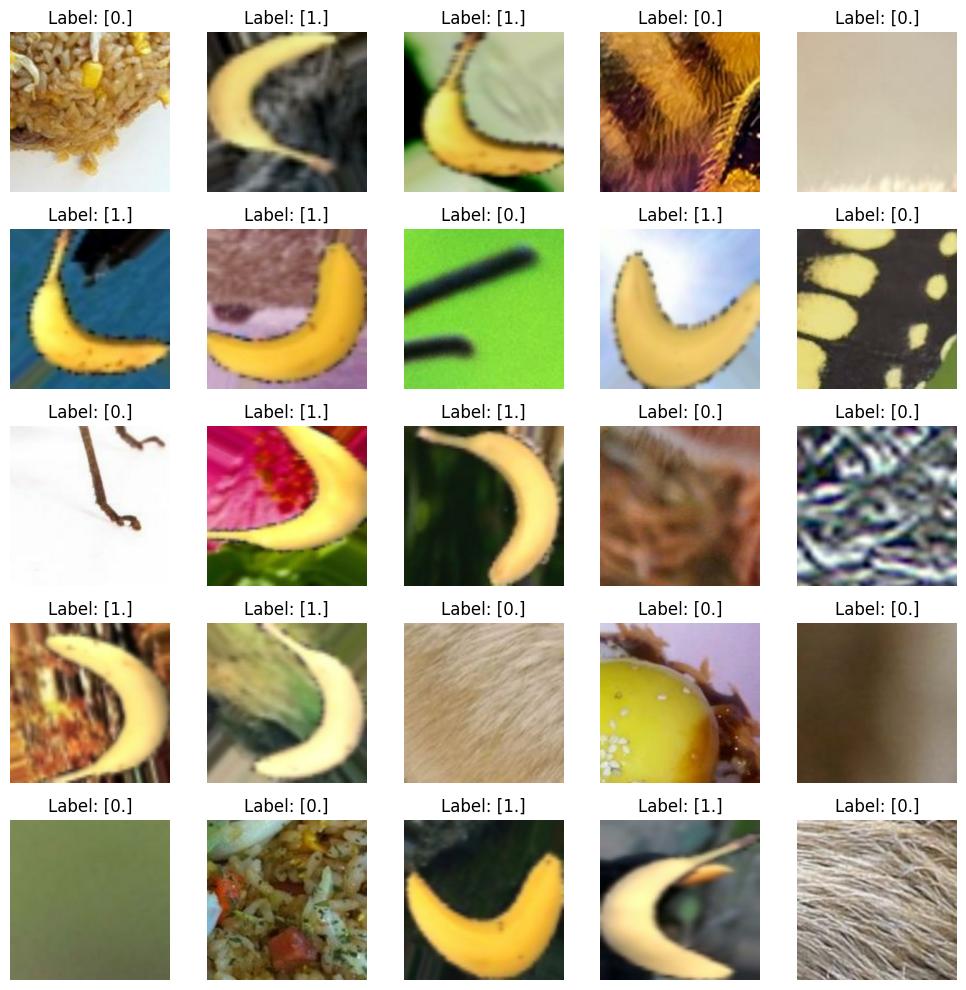

In [8]:
import matplotlib.pyplot as plt

# Function to visualize 20 samples from a tf.data.Dataset in a 5x5 grid
def view_dataset_grid(dataset, num_samples=25):
    plt.figure(figsize=(10, 10))

    for i, (images, labels) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(5, 5, i + 1)  # Create a 5x5 grid
        image = images[0]  # Index the first image in the batch
        image = (image).numpy().astype("uint8")  # Rescale if necessary
        plt.imshow(image.squeeze())  # Squeeze in case of grayscale
        plt.title(f"Label: {labels[0].numpy()}")  # Index the first label
        plt.axis("off")

    # If there are fewer than 25 samples, fill the remaining grid cells with empty plots
    for j in range(i + 1, 25):
        ax = plt.subplot(5, 5, j + 1)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize 20 samples from your dataset in a 5x5 grid
view_dataset_grid(augmented_train_dataset, num_samples=25)


# Transfer Learning from a Deep Model

In [83]:
input_shape = (224, 224, 3)  # Assuming input shape
num_classes = 1  # For binary classification

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)  # Ensure the base model is in inference mode

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64,
                          kernel_regularizer=l2(l2=0.05),
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128,
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256,
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512,
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output layer for binary classification
outputs = tf.keras.layers.Dense(num_classes,
                                activation='sigmoid')(x)

# Create the final model
model = tf.keras.models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_focal_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,594,177 (63.30 MB)

 Trainable params: 1,829,313 (6.98 MB)

 Non-trainable params: 14,764,864 (56.32 MB)

In [84]:
# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.keras',
        monitor='val_loss', save_best_only=True, verbose=1),

    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # Monitor the validation loss
        factor=0.1,          # Reduce the learning rate by a factor of 10
        patience=1,          # Wait 5 epochs after the last improvement
        min_lr=1e-14,         # Minimum learning rate
        mode='auto',         # Auto mode: minimize the monitored metric
        verbose=1)            # Print a message when learning rate is reduced
]

In [85]:
epochs = 10

model.optimizer.learning_rate=1e-3

for layer in base_model.layers:
    layer.trainable = False  # Unlock all layers

history = model.fit(
        augmented_train_dataset,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=normalized_validation_dataset,
        shuffle=True,
        verbose = 1)

Epoch 1/10
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9556 - loss: 2.1407
Epoch 1: val_loss improved from inf to 1.63591, saving model to model.keras
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 503s 73ms/step - accuracy: 0.9556 - loss: 2.1406 - val_accuracy: 0.9980 - val_loss: 1.6359 - learning_rate: 0.0010
Epoch 2/10
6821/6822 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9762 - loss: 2.0037
Epoch 2: val_loss improved from 1.63591 to 1.52632, saving model to model.keras
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 619s 91ms/step - accuracy: 0.9762 - loss: 2.0037 - val_accuracy: 0.9968 - val_loss: 1.5263 - learning_rate: 0.0010
Epoch 3/10
6821/6822 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9771 - loss: 1.8777
Epoch 3: val_loss did not improve from 1.52632

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 503s 73ms/step - accuracy: 0.9771 - loss: 1.8777 - val_accuracy: 0.9968 - val_loss: 2.5799 - learning_rate: 0.0010
Epoch 4/10
682

In [ ]:
epochs = 3
# Fine Tuning
model.optimizer.learning_rate=1e-8

for layer in base_model.layers:
    layer.trainable = True  # Unlock all layers

history = model.fit(
        augmented_train_dataset,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=normalized_validation_dataset,
        shuffle=True,
        verbose = 1)

Epoch 1/3
6821/6822 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9975 - loss: 0.0270
Epoch 1: val_loss improved from 0.01937 to 0.01932, saving model to model.keras
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 501s 73ms/step - accuracy: 0.9975 - loss: 0.0270 - val_accuracy: 0.9999 - val_loss: 0.0193 - learning_rate: 1.0000e-08
Epoch 2/3
6821/6822 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9972 - loss: 0.0278
Epoch 2: val_loss improved from 0.01932 to 0.01929, saving model to model.keras

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
6822/6822 ━━━━━━━━━━━━━━━━━━━━ 550s 81ms/step - accuracy: 0.9972 - loss: 0.0278 - val_accuracy: 0.9999 - val_loss: 0.0193 - learning_rate: 1.0000e-08
Epoch 3/3
2283/6822 ━━━━━━━━━━━━━━━━━━━━ 4:23 58ms/step - accuracy: 0.9976 - loss: 0.0314

Vamos ver o resultado

In [87]:
def pred_images_transf(ROIs):
  images = tf.convert_to_tensor(np.array([keras.utils.img_to_array(x[0]) for x in ROIs]))
  #input_images = keras.applications.vgg16.preprocess_input(images)
  preds_1 = model.predict(images, verbose=0) * 100
  pred_rect = []

  for i, ROI in enumerate(ROIs):
    pred_rect.append(ROIs[i][1])

  return pred_rect, preds_1, np.max(preds_1)

In [88]:
import pickle
import zipfile
# Função para carregar dados de um arquivo zip
def load_data_from_zip(zip_filename):
    loaded_data = []
    with zipfile.ZipFile(zip_filename, 'r') as zf:
        for filename in zf.namelist():
            with zf.open(filename) as f:
                data_dict = pickle.loads(f.read())
                loaded_data.append((data_dict['inpp'], data_dict['roi_imgs'], data_dict['actual_rects']))
    return loaded_data

# Caminho do arquivo zip para salvar e carregar os dados
zip_filename = '/content/drive/MyDrive/roi_data21_25_full.zip'

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_iou(box1, box2):
    """
    Calcula a IoU (Intersection over Union) entre duas caixas delimitadoras.

    Args:
        box1: Caixa delimitadora no formato [x1, y1, x2, y2].
        box2: Caixa delimitadora no formato [x1, y1, x2, y2].

    Returns:
        iou: Valor de IoU.
    """
    # Coordenadas da interseção
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Dimensões da interseção
    inter_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Áreas das caixas
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Área da união
    union_area = box1_area + box2_area - inter_area

    # Calcula IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [90]:
import csv
with open('banana-detection/bananas_train/label.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    data_train = [row for row in csv_reader]
with open('banana-detection/bananas_val/label.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    data_test = [row for row in csv_reader]
x_train = ["banana-detection/bananas_train/images/" + x.get('img_name') for x in data_train]
y_train = np.array([[int(x.get('xmin')),int(x.get('ymin')),int(x.get('xmax')),int(x.get('ymax'))] for x in data_train], dtype=np.int32)
x_test = ["banana-detection/bananas_val/images/" + x.get('img_name') for x in data_test]
y_test = np.array([[int(x.get('xmin')),int(x.get('ymin')),int(x.get('xmax')),int(x.get('ymax'))] for x in data_test], dtype=np.int32)


In [91]:

import time
p_test = []
# Segundo loop: Classificação e salvamento de resultados
prestart_2 = time.time()
loaded_data = load_data_from_zip(zip_filename)

for i, (inpp, roi_imgs, actual_rects) in enumerate(loaded_data):
    start = time.time()

    # Classificação da Melhor ROI
    print(f'Classificando {inpp} ROIs: {len(actual_rects)}')
    pred, probs, prob = pred_images_transf(roi_imgs)
    maxRect = pred[np.argmax(probs)]
    end = time.time()

    # Calcular IoU
    iou = calculate_iou(y_test[i], maxRect)  # Assumindo que y_test contém as caixas verdadeiras

    # Probabilidade e Rect
    print(f'Box Rede: {maxRect} - Prob. {prob} - IoU: {iou:.4f}')  # Imprime o IoU com 4 casas decimais
    p_test.append([inpp, maxRect])
    print(f'Box Original: {y_test[i]}')

    # Salva imagem
    #save_output(inpp, pred, i, probs)

    # Tempo gasto para essa imagem
    print(f'Classificação dos ROIs levou {round(end - start)} segundos')

preend_2 = time.time()
tempo2 = round(preend_2 - prestart_2)
print(f'Tempo total: {round(tempo2)} segundos')


Classificando banana-detection/bananas_val/images/0.png ROIs: 23
Box Rede: (183, 64, 239, 111) - Prob. 100.0 - IoU: 0.9275
Box Original: [183  63 241 112]
Classificação dos ROIs levou 1 segundos
Classificando banana-detection/bananas_val/images/1.png ROIs: 40
Box Rede: (27, 86, 77, 132) - Prob. 99.99998474121094 - IoU: 0.9248
Box Original: [ 26  86  79 133]
Classificação dos ROIs levou 1 segundos
Classificando banana-detection/bananas_val/images/2.png ROIs: 31
Box Rede: (139, 108, 177, 147) - Prob. 100.0 - IoU: 0.9512
Box Original: [139 108 178 148]
Classificação dos ROIs levou 1 segundos
Classificando banana-detection/bananas_val/images/3.png ROIs: 27
Box Rede: (21, 131, 61, 169) - Prob. 99.9998779296875 - IoU: 0.8864
Box Original: [ 20 130  63 170]
Classificação dos ROIs levou 1 segundos
Classificando banana-detection/bananas_val/images/4.png ROIs: 5
Box Rede: (30, 103, 97, 151) - Prob. 100.0 - IoU: 0.9658
Box Original: [ 30 103  98 152]
Classificação dos ROIs levou 1 segundos
Classi

In [92]:
from sklearn.metrics import mean_absolute_error
y_pred = np.array([x for x in np.array(p_test, dtype=object)[:,1]])
mae = mean_absolute_error(y_test[0:len(y_pred)], y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.8000


IoU média: 0.9377117447082414
IoU mínima: 0.8735689397710303
Posição da IoU mínima: 70


<ipython-input-93-776754153759>:39: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = plt.stem(indices, ious, basefmt=" ", label='IoUs', use_line_collection=True)


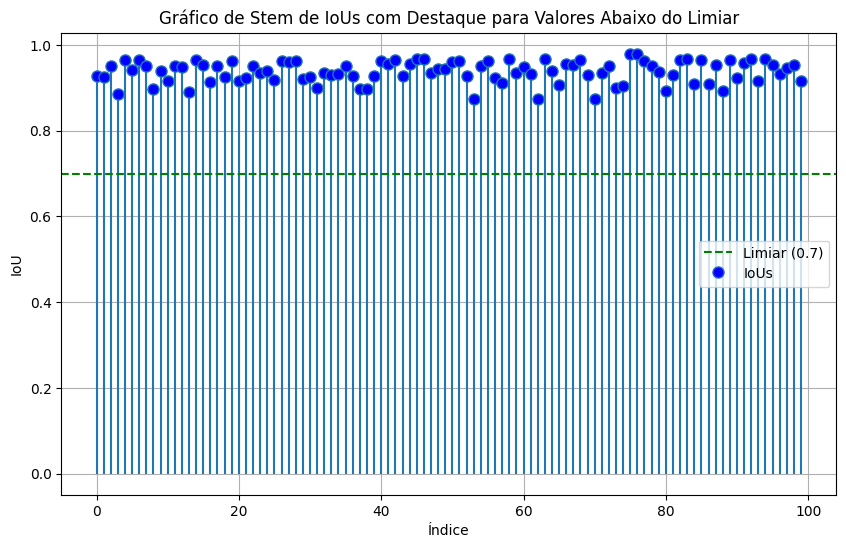

In [93]:
def calculate_mean_and_min_iou(y_test, y_pred):
    """
    Calcula a IoU média e mínima entre duas listas de caixas delimitadoras.

    Args:
        y_test: Lista de caixas reais (ground truth) no formato [x1, y1, x2, y2].
        y_pred: Lista de caixas previstas no formato [x1, y1, x2, y2].

    Returns:
        mean_iou: A IoU média entre as caixas.
        min_iou: A menor IoU entre as caixas.
        min_iou_index: A posição (índice) da menor IoU.
        ious: Lista de todas as IoUs calculadas.
    """
    ious = []
    for i in range(len(y_pred)):
        iou = calculate_iou(y_test[i], y_pred[i])
        ious.append(iou)

    # Calcula a média e o mínimo das IoUs
    mean_iou = np.mean(ious) if len(ious) > 0 else 0
    min_iou = np.min(ious) if len(ious) > 0 else 0
    min_iou_index = int(np.argmin(ious)) if len(ious) > 0 else -1

    return mean_iou, min_iou, min_iou_index, ious

def plot_stem_ious_with_annotations(ious, threshold=0.7):
    """
    Plota um gráfico de stem das IoUs e anota os índices menores que o limiar ao lado das bolinhas vermelhas.

    Args:
        ious: Lista de IoUs.
        threshold: Limiar para detectar IoUs baixas (default = 0.7).
    """
    indices = range(len(ious))

    # Plotar o gráfico de stem com todas as IoUs
    plt.figure(figsize=(10, 6))
    markerline, stemlines, baseline = plt.stem(indices, ious, basefmt=" ", label='IoUs', use_line_collection=True)
    plt.setp(markerline, 'markerfacecolor', 'b', 'markersize', 8)  # Definir as bolinhas azuis para IoUs

    # Plotar a linha do limiar
    plt.axhline(y=threshold, color='g', linestyle='--', label=f'Limiar ({threshold})')

    # Encontrar índices onde a IoU é menor que o threshold
    low_iou_indices = [i for i, iou in enumerate(ious) if iou < threshold]

    # Anotar e destacar as IoUs menores que o limiar
    for idx in low_iou_indices:
        plt.plot(idx, ious[idx], 'ro')  # Bolinha vermelha para IoUs menores que o threshold
        plt.text(idx, ious[idx], f'{idx}', color='red', fontsize=12, ha='left', va='bottom')  # Adicionar índice

    # Configurações do gráfico
    plt.xlabel('Índice')
    plt.ylabel('IoU')
    plt.title('Gráfico de Stem de IoUs com Destaque para Valores Abaixo do Limiar')
    plt.legend()
    plt.grid(True)
    plt.show()

# Cálculo Médio e Mínimo IoU
mean_iou, min_iou, min_iou_index, ious = calculate_mean_and_min_iou(y_test, y_pred)

print("IoU média:", mean_iou)
print("IoU mínima:", min_iou)
print("Posição da IoU mínima:", min_iou_index)

# Plotar o gráfico de stem com anotações para IoUs menores que 0.7
plot_stem_ious_with_annotations(ious, threshold=0.7)


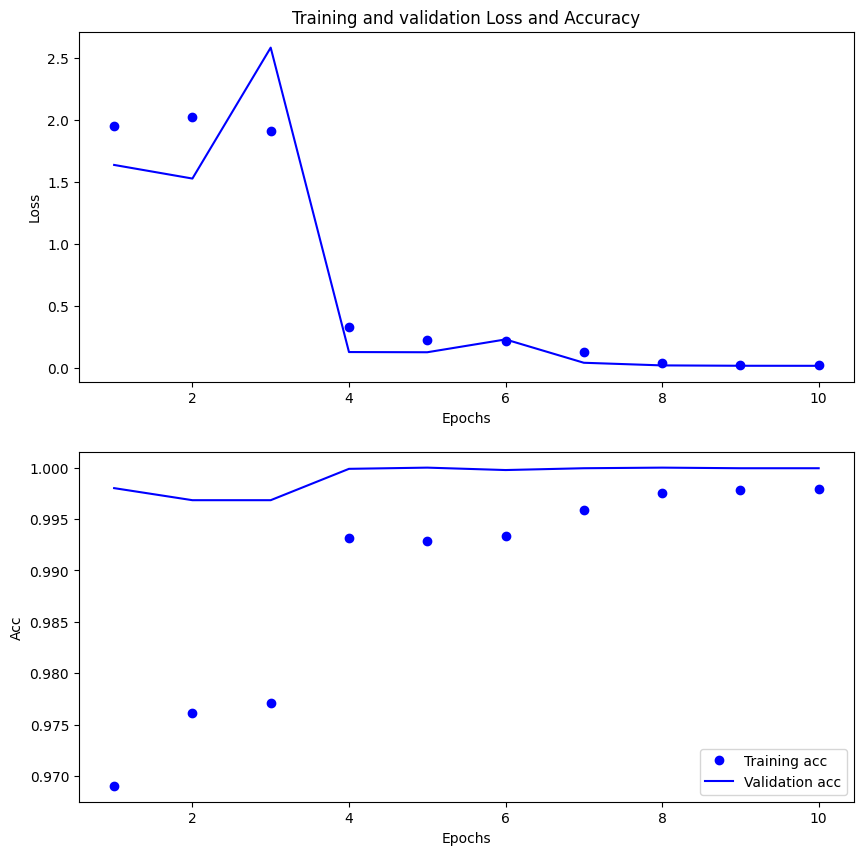

In [94]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [95]:
# Using the validation dataset
score = model.evaluate(validation_dataset)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

1706/1706 ━━━━━━━━━━━━━━━━━━━━ 92s 54ms/step - accuracy: 0.9998 - loss: 0.0201
Val loss: 0.019307652488350868
Val accuracy: 0.999941349029541


In [96]:
# Using the test dataset
score = model.evaluate(test_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 0.0190
Test loss: 0.018962636590003967
Test accuracy: 1.0
